## কার্টপোল স্কেটিং

> **সমস্যা**: যদি পিটারকে নেকড়ের কাছ থেকে পালাতে হয়, তাহলে তাকে নেকড়ের চেয়ে দ্রুত চলতে হবে। আমরা দেখব কীভাবে পিটার স্কেটিং শিখতে পারে, বিশেষ করে, ভারসাম্য বজায় রাখতে, Q-Learning ব্যবহার করে।

প্রথমে, জিম ইনস্টল করি এবং প্রয়োজনীয় লাইব্রেরিগুলো ইমপোর্ট করি:


In [1]:
import sys
!pip install gym 

import gym
import matplotlib.pyplot as plt
import numpy as np
import random

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.


## একটি কার্টপোল পরিবেশ তৈরি করুন


In [2]:
env = gym.make("CartPole-v1")
print(env.action_space)
print(env.observation_space)
print(env.action_space.sample())

Discrete(2)
Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
0


পরিবেশ কীভাবে কাজ করে তা দেখতে, চলুন ১০০ ধাপের জন্য একটি ছোট সিমুলেশন চালাই।


In [3]:
env.reset()

for i in range(100):
   env.render()
   env.step(env.action_space.sample())
env.close()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


সিমুলেশনের সময়, আমাদের পর্যবেক্ষণগুলি পেতে হবে যাতে আমরা কীভাবে কাজ করব তা নির্ধারণ করতে পারি। প্রকৃতপক্ষে, `step` ফাংশন আমাদের বর্তমান পর্যবেক্ষণ, পুরস্কার ফাংশন, এবং `done` ফ্ল্যাগ ফেরত দেয় যা নির্দেশ করে যে সিমুলেশন চালিয়ে যাওয়া যৌক্তিক কিনা:


In [4]:
env.reset()

done = False
while not done:
   env.render()
   obs, rew, done, info = env.step(env.action_space.sample())
   print(f"{obs} -> {rew}")
env.close()

[ 0.03044442 -0.19543914 -0.04496216  0.28125618] -> 1.0
[ 0.02653564 -0.38989186 -0.03933704  0.55942606] -> 1.0
[ 0.0187378  -0.19424049 -0.02814852  0.25461393] -> 1.0
[ 0.01485299 -0.38894946 -0.02305624  0.53828712] -> 1.0
[ 0.007074   -0.19351108 -0.0122905   0.23842953] -> 1.0
[ 0.00320378  0.00178427 -0.00752191 -0.05810469] -> 1.0
[ 0.00323946  0.19701326 -0.008684   -0.35315131] -> 1.0
[ 0.00717973  0.00201587 -0.01574703 -0.06321931] -> 1.0
[ 0.00722005  0.19736001 -0.01701141 -0.36082863] -> 1.0
[ 0.01116725  0.39271958 -0.02422798 -0.65882671] -> 1.0
[ 0.01902164  0.19794307 -0.03740452 -0.37387001] -> 1.0
[ 0.0229805   0.39357584 -0.04488192 -0.67810827] -> 1.0
[ 0.03085202  0.58929164 -0.05844408 -0.98457719] -> 1.0
[ 0.04263785  0.78514572 -0.07813563 -1.2950295 ] -> 1.0
[ 0.05834076  0.98116859 -0.10403622 -1.61111521] -> 1.0
[ 0.07796413  0.78741784 -0.13625852 -1.35259196] -> 1.0
[ 0.09371249  0.98396202 -0.16331036 -1.68461179] -> 1.0
[ 0.11339173  0.79106371 -0.197

আমরা সেই সংখ্যাগুলোর সর্বনিম্ন এবং সর্বাধিক মান পেতে পারি:


In [5]:
print(env.observation_space.low)
print(env.observation_space.high)

[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


In [6]:
def discretize(x):
    return tuple((x/np.array([0.25, 0.25, 0.01, 0.1])).astype(np.int))

চলুন বিন ব্যবহার করে অন্যান্য বিচ্ছিন্নকরণ পদ্ধতি অন্বেষণ করি:


In [7]:
def create_bins(i,num):
    return np.arange(num+1)*(i[1]-i[0])/num+i[0]

print("Sample bins for interval (-5,5) with 10 bins\n",create_bins((-5,5),10))

ints = [(-5,5),(-2,2),(-0.5,0.5),(-2,2)] # intervals of values for each parameter
nbins = [20,20,10,10] # number of bins for each parameter
bins = [create_bins(ints[i],nbins[i]) for i in range(4)]

def discretize_bins(x):
    return tuple(np.digitize(x[i],bins[i]) for i in range(4))

Sample bins for interval (-5,5) with 10 bins
 [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


এবার একটি সংক্ষিপ্ত সিমুলেশন চালাই এবং সেই বিচ্ছিন্ন পরিবেশের মানগুলো পর্যবেক্ষণ করি।


In [8]:
env.reset()

done = False
while not done:
   #env.render()
   obs, rew, done, info = env.step(env.action_space.sample())
   #print(discretize_bins(obs))
   print(discretize(obs))
env.close()

(0, 0, -1, -3)
(0, 0, -2, 0)
(0, 0, -2, -3)
(0, 1, -3, -6)
(0, 2, -4, -9)
(0, 3, -6, -12)
(0, 2, -8, -9)
(0, 3, -10, -13)
(0, 4, -13, -16)
(0, 4, -16, -19)
(0, 4, -20, -17)
(0, 4, -24, -20)


## কিউ-টেবিলের গঠন


In [9]:
Q = {}
actions = (0,1)

def qvalues(state):
    return [Q.get((state,a),0) for a in actions]

In [10]:
# hyperparameters
alpha = 0.3
gamma = 0.9
epsilon = 0.90

In [11]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Qmax = 0
cum_rewards = []
rewards = []
for epoch in range(100000):
    obs = env.reset()
    done = False
    cum_reward=0
    # == do the simulation ==
    while not done:
        s = discretize(obs)
        if random.random()<epsilon:
            # exploitation - chose the action according to Q-Table probabilities
            v = probs(np.array(qvalues(s)))
            a = random.choices(actions,weights=v)[0]
        else:
            # exploration - randomly chose the action
            a = np.random.randint(env.action_space.n)

        obs, rew, done, info = env.step(a)
        cum_reward+=rew
        ns = discretize(obs)
        Q[(s,a)] = (1 - alpha) * Q.get((s,a),0) + alpha * (rew + gamma * max(qvalues(ns)))
    cum_rewards.append(cum_reward)
    rewards.append(cum_reward)
    # == Periodically print results and calculate average reward ==
    if epoch%5000==0:
        print(f"{epoch}: {np.average(cum_rewards)}, alpha={alpha}, epsilon={epsilon}")
        if np.average(cum_rewards) > Qmax:
            Qmax = np.average(cum_rewards)
            Qbest = Q
        cum_rewards=[]

0: 108.0, alpha=0.3, epsilon=0.9


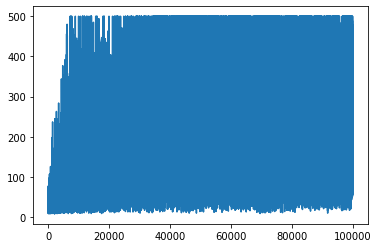

In [20]:
plt.plot(rewards)

এই গ্রাফ থেকে কিছু বলা সম্ভব নয়, কারণ স্টোকাস্টিক প্রশিক্ষণ প্রক্রিয়ার প্রকৃতির কারণে প্রশিক্ষণ সেশনের দৈর্ঘ্য ব্যাপকভাবে পরিবর্তিত হয়। এই গ্রাফটি আরও অর্থবহ করতে, আমরা পরীক্ষার সিরিজের উপর **চলমান গড়** গণনা করতে পারি, ধরুন ১০০। এটি সুবিধাজনকভাবে `np.convolve` ব্যবহার করে করা যেতে পারে:


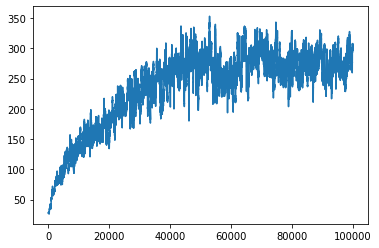

In [22]:
def running_average(x,window):
    return np.convolve(x,np.ones(window)/window,mode='valid')

plt.plot(running_average(rewards,100))

## হাইপারপ্যারামিটার পরিবর্তন এবং ফলাফল পর্যবেক্ষণ

এখন প্রশিক্ষিত মডেলটি কীভাবে আচরণ করে তা বাস্তবে দেখা বেশ আকর্ষণীয় হবে। চলুন সিমুলেশন চালাই, এবং আমরা প্রশিক্ষণের সময় ব্যবহৃত একই অ্যাকশন নির্বাচন কৌশল অনুসরণ করব: Q-টেবিলের প্রোবাবিলিটি ডিস্ট্রিবিউশন অনুযায়ী স্যাম্পলিং।


In [23]:
obs = env.reset()
done = False
while not done:
   s = discretize(obs)
   env.render()
   v = probs(np.array(qvalues(s)))
   a = random.choices(actions,weights=v)[0]
   obs,_,done,_ = env.step(a)
env.close()

## ফলাফল একটি অ্যানিমেটেড GIF-এ সংরক্ষণ করা

আপনি যদি আপনার বন্ধুদের মুগ্ধ করতে চান, তাহলে আপনি ব্যালেন্সিং পোলের অ্যানিমেটেড GIF ছবি পাঠাতে পারেন। এটি করতে, আমরা `env.render` ব্যবহার করে একটি ইমেজ ফ্রেম তৈরি করতে পারি এবং তারপর সেগুলো PIL লাইব্রেরি ব্যবহার করে অ্যানিমেটেড GIF-এ সংরক্ষণ করতে পারি:


In [26]:
from PIL import Image
obs = env.reset()
done = False
i=0
ims = []
while not done:
   s = discretize(obs)
   img=env.render(mode='rgb_array')
   ims.append(Image.fromarray(img))
   v = probs(np.array([Qbest.get((s,a),0) for a in actions]))
   a = random.choices(actions,weights=v)[0]
   obs,_,done,_ = env.step(a)
   i+=1
env.close()
ims[0].save('images/cartpole-balance.gif',save_all=True,append_images=ims[1::2],loop=0,duration=5)
print(i)

360



---

**অস্বীকৃতি**:  
এই নথিটি AI অনুবাদ পরিষেবা [Co-op Translator](https://github.com/Azure/co-op-translator) ব্যবহার করে অনুবাদ করা হয়েছে। আমরা যথাসম্ভব সঠিক অনুবাদ প্রদানের চেষ্টা করি, তবে অনুগ্রহ করে মনে রাখবেন যে স্বয়ংক্রিয় অনুবাদে ত্রুটি বা অসঙ্গতি থাকতে পারে। মূল ভাষায় থাকা নথিটিকে প্রামাণিক উৎস হিসেবে বিবেচনা করা উচিত। গুরুত্বপূর্ণ তথ্যের জন্য, পেশাদার মানব অনুবাদ সুপারিশ করা হয়। এই অনুবাদ ব্যবহারের ফলে কোনো ভুল বোঝাবুঝি বা ভুল ব্যাখ্যা হলে আমরা দায়বদ্ধ থাকব না।
